# Prysm RLNC Multi-Network Block Arrivals Analysis

This notebook analyzes the impact of Reed-Solomon Linear Network Coding (RLNC) implementation by Prysm on beacon block propagation times. We compare block arrival times and block sizes across three networks: devnet-5, devnet-6, and devnet-7.

In [1]:
# Import necessary packages
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from sqlalchemy import create_engine, text
from datetime import datetime, timedelta

# Add scripts directory to path
sys.path.append('./scripts')

# Import custom modules
from bootstrap import load_env, create_db_url, add_branding, process_config
from clickhouse import ClickhouseClient
from transforms_multi import process_block_data, process_block_size_data, calculate_arrival_metrics, compare_networks_multi

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

/Users/samcm/.pyenv/versions/anaconda3-2022.05/envs/ldm/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Configuration
config = {
    "networks": {
        "devnet-6": {
            "network": "nft-devnet-6",
            "label": "baseline",
            "start_at_slot": 300,
            "finish_at_slot": 600
        },
        "devnet-5": {
            "network": "nft-devnet-5",
            "label": "rlnc",
            "start_at_slot": 300,
            "finish_at_slot": 600
        },
        # "devnet-7": {
        #     "network": "nft-devnet-7",
        #     "label": "experiment",
        #     "start_at_slot": 300,
        #     "finish_at_slot": 600
        # }
    }
}

# Validate and process the config
config = process_config(config)

# Load environment variables
credentials = load_env()
db_url = create_db_url(credentials)

# Initialize Clickhouse client
clickhouse = ClickhouseClient(db_url)

## Data Collection

Let's collect block arrival data from all three networks.

In [3]:
# Dictionaries to store data for each network
block_data = {}
block_size_data = {}

# Fetch data for each network
for network_key, network_config in config['networks'].items():
    print(f"Fetching data for {network_config['network']} ({network_key})...")
    
    block_data[network_key] = clickhouse.fetch_block_arrival_times(
        network_config['network'], 
        network_config['start_at_slot'], 
        network_config['finish_at_slot']
    )
    
    block_size_data[network_key] = clickhouse.fetch_block_size_data(
        network_config['network'], 
        network_config['start_at_slot'], 
        network_config['finish_at_slot']
    )

Fetching data for nft-devnet-6 (devnet-6)...
Fetching data for nft-devnet-5 (devnet-5)...


## Data Processing

Now let's process the data to calculate metrics for all networks.

In [4]:
# Process data for each network
combined_data = {}
block_size_processed = {}
metrics = {}

for network_key in config['networks'].keys():
    # Process block data
    combined_data[network_key] = process_block_data(block_data[network_key])
    
    # Process block size data
    block_size_processed[network_key] = process_block_size_data(block_size_data[network_key])
    
    # Calculate metrics
    metrics[network_key] = calculate_arrival_metrics(
        combined_data[network_key],
        block_size_processed[network_key]
    )
    
    # Add network label for visualization
    metrics[network_key]['network'] = network_key

# Combine for easier comparison
all_metrics = pd.concat(metrics.values(), ignore_index=True)

# Show summary statistics
print("Dataset summary:")
for network_key, network_config in config['networks'].items():
    print(f"{network_config['label']} ({network_config['network']}): {len(metrics[network_key])} slots, {combined_data[network_key]['meta_client_name'].nunique()} unique clients")

# Compare the networks
comparison = compare_networks_multi(metrics)

# Display pairwise comparisons for key metrics
print("\nPairwise comparisons of arrival times:")
for pair_key in [key for key in comparison.keys() if '_vs_' in key]:
    network1, network2 = pair_key.split('_vs_')
    print(f"\n{config['networks'][network1]['label']} vs {config['networks'][network2]['label']}:")
    
    for metric in ['min_arrival_time', 'p50_arrival_time', 'p95_arrival_time']:
        val1 = comparison[pair_key][metric][network1]
        val2 = comparison[pair_key][metric][network2]
        diff = comparison[pair_key][metric]['difference']
        pct = comparison[pair_key][metric]['improvement_percent']
        
        print(f"{metric.replace('_arrival_time', '')}: {val1:.1f}ms → {val2:.1f}ms ({diff:.1f}ms difference, {pct:.1f}% {('improvement' if pct > 0 else 'increase')})")

Dataset summary:
baseline (nft-devnet-6): 301 slots, 145 unique clients
rlnc (nft-devnet-5): 301 slots, 146 unique clients

Pairwise comparisons of arrival times:

baseline vs rlnc:
min: 2478.4ms → 2816.6ms (-338.2ms difference, -13.6% increase)
p50: 2975.0ms → 3226.0ms (-251.0ms difference, -8.4% increase)
p95: 3488.4ms → 3687.4ms (-198.9ms difference, -5.7% increase)


## Visualization: Block Arrival Time Comparison Across Networks

Let's create visualizations to compare all three networks.

/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_30309/3238481116.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect parameter to leave space for title


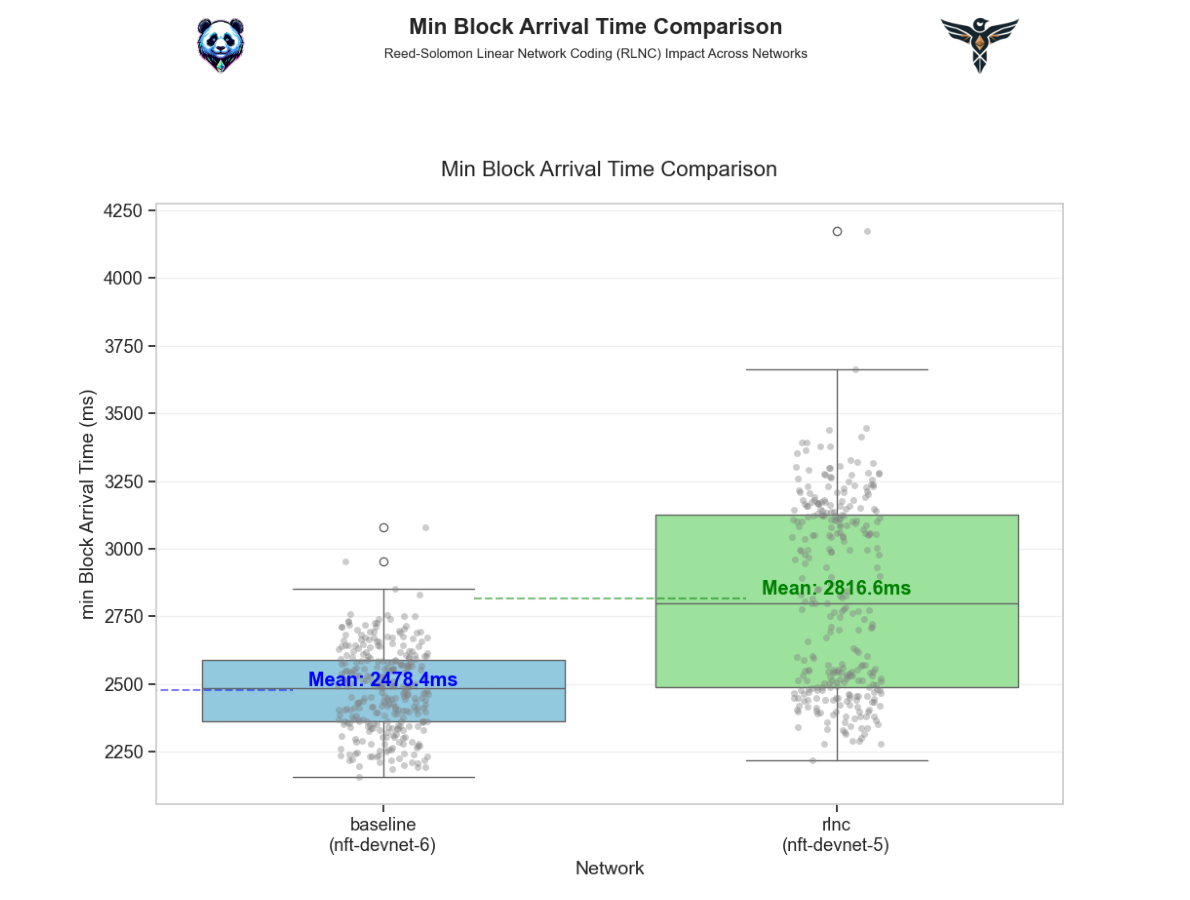

/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_30309/3238481116.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect parameter to leave space for title


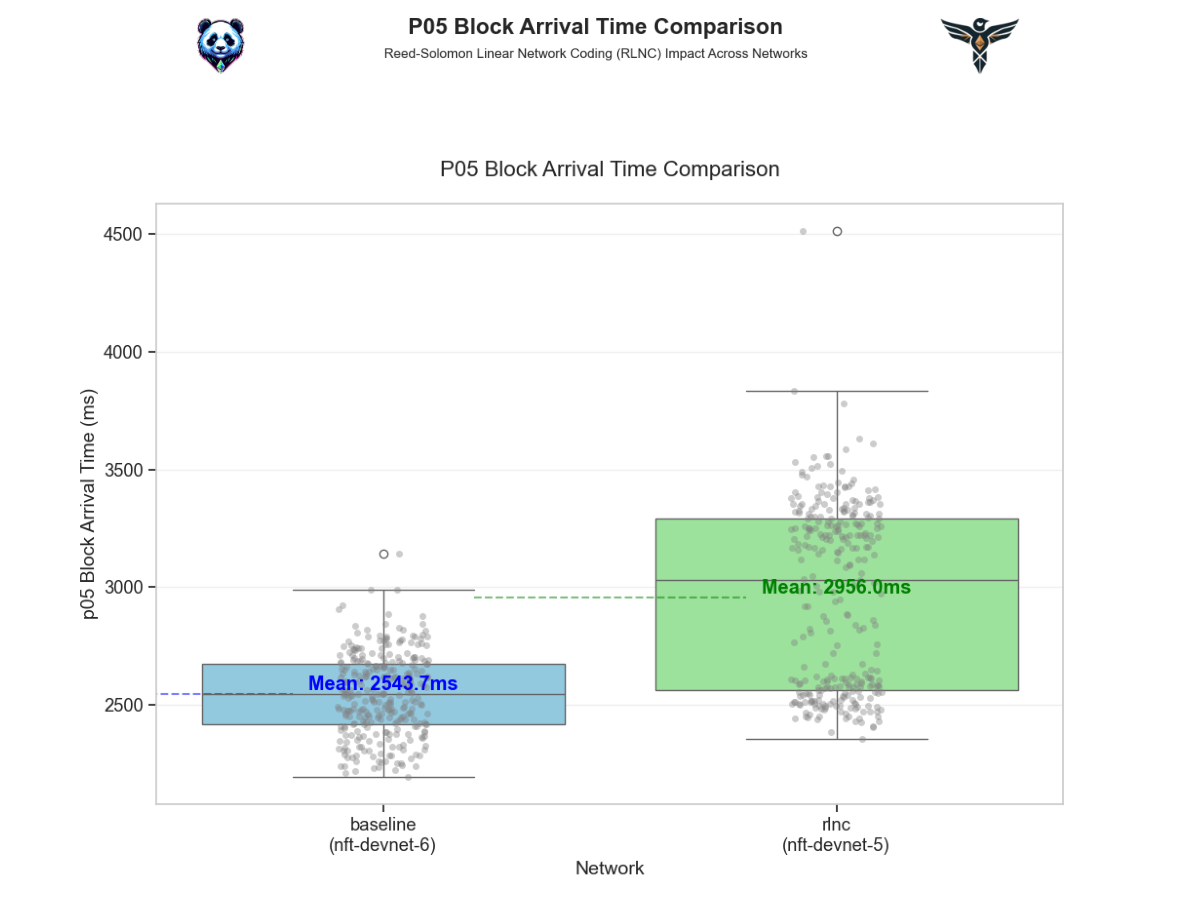

/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_30309/3238481116.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect parameter to leave space for title


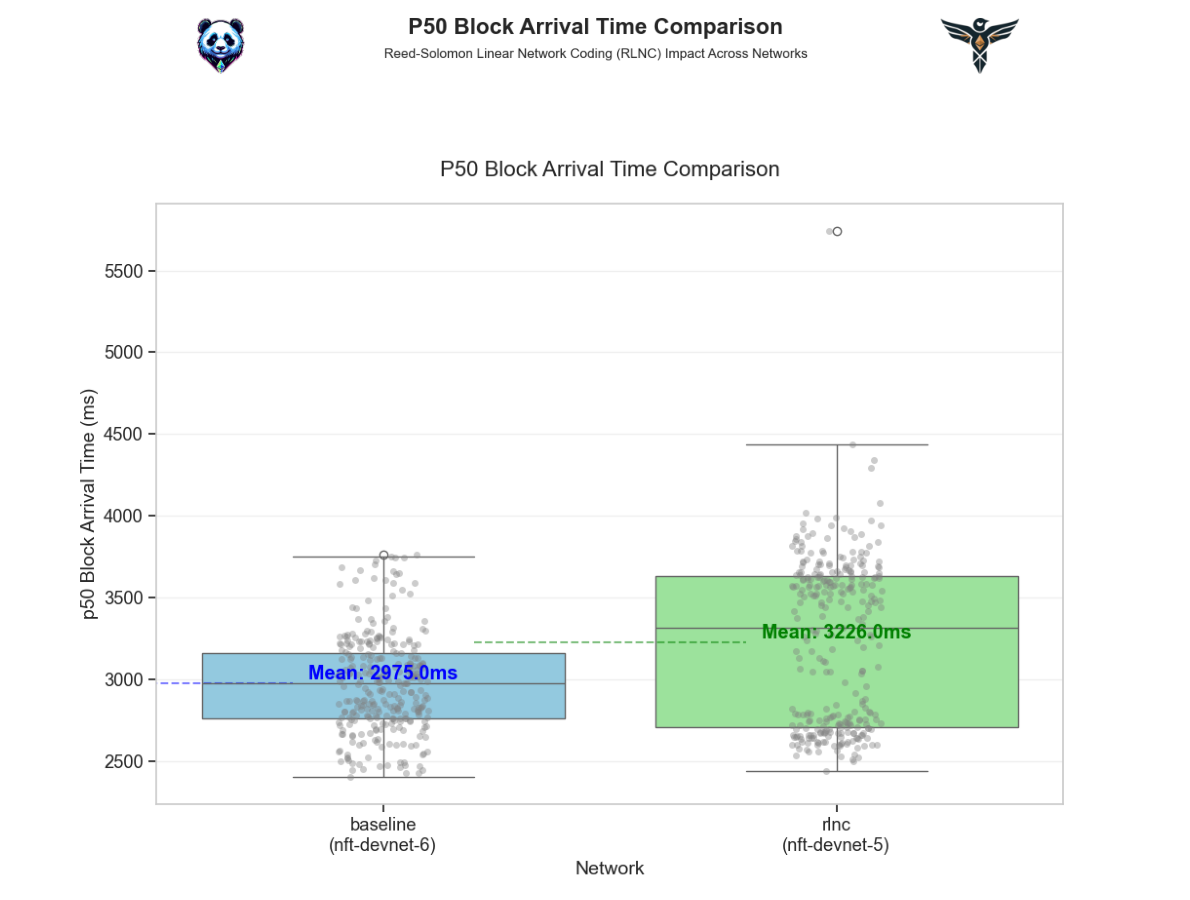

/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_30309/3238481116.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect parameter to leave space for title


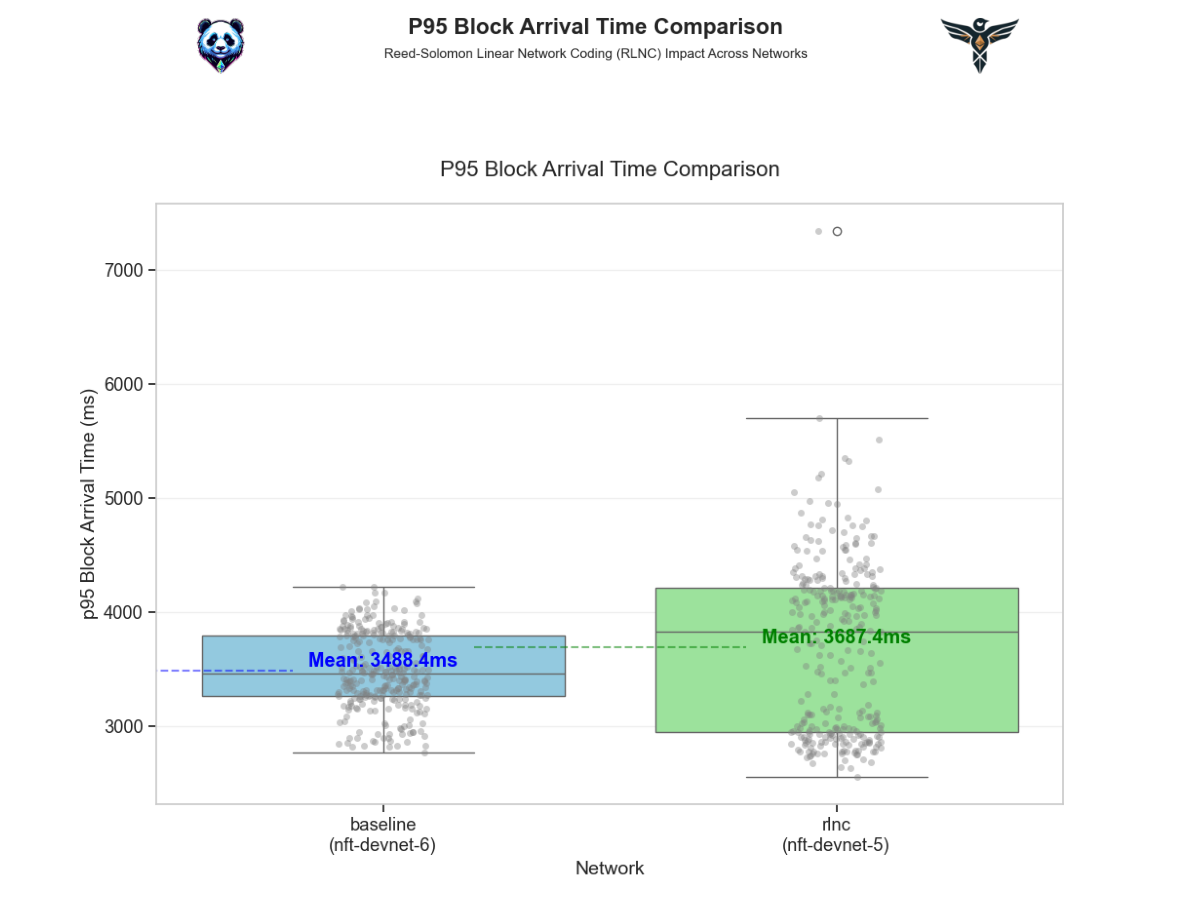

In [5]:
def create_multi_network_boxplot(metrics_df, metric='p50_arrival_time', title=None, subtitle=None):
    """
    Create a box plot comparing networks for a specified metric.
    
    Args:
        metrics_df (DataFrame): Combined metrics from all networks
        metric (str): The metric to plot
        title (str, optional): Title for the plot
        subtitle (str, optional): Subtitle for the plot
        
    Returns:
        matplotlib.figure.Figure: The figure with the plot
    """
    networks = metrics_df['network'].unique()
    network_count = len(networks)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create labels mapping
    labels = {network: config["networks"][network]["label"] for network in networks}
    
    # Set x-ticks before creating the boxplot
    ax.set_xticks(range(network_count))
    ax.set_xticklabels([f'{labels[network]}\n({config["networks"][network]["network"]})' for network in networks])
    
    # Create box plot with hue parameter for color differentiation
    sns.boxplot(
        x='network', 
        y=metric,
        hue='network', 
        data=metrics_df,
        palette={'devnet-5': 'lightgreen', 'devnet-6': 'skyblue', 'devnet-7': 'coral'},
        ax=ax,
        legend=False
    )
    
    # Add individual data points
    sns.stripplot(
        x='network', 
        y=metric, 
        data=metrics_df,
        color='gray',
        alpha=0.4,
        jitter=True,
        ax=ax
    )
    
    # Set axis labels and title
    ax.set_xlabel('Network', fontsize=14)
    ax.set_ylabel(f'{metric.replace("_arrival_time", "")} Block Arrival Time (ms)', fontsize=14)
    
    if title:
        ax.set_title(title, fontsize=16, pad=20)
    
    # Add grid for readability
    ax.grid(True, axis='y', alpha=0.3)
    
    # Add average lines for each network
    for i, network in enumerate(networks):
        network_data = metrics_df[metrics_df['network'] == network][metric]
        if not network_data.empty:
            network_avg = network_data.mean()
            # Add horizontal line at the average with appropriate span
            span_start = i - 0.3
            span_end = i + 0.3
            line_colors = {'devnet-5': 'green', 'devnet-6': 'blue', 'devnet-7': 'red'}
            
            ax.axhline(network_avg, color=line_colors[network], linestyle='--', alpha=0.5, 
                      xmin=span_start/network_count, xmax=span_end/network_count)
            
            # Add text with the average value
            ax.text(i, network_avg, f'Mean: {network_avg:.1f}ms', 
                   ha='center', va='bottom', color=line_colors[network], fontweight='bold')
    
    # Add branding if title and subtitle are provided
    if title and subtitle:
        fig = add_branding(fig, title, subtitle)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect parameter to leave space for title
    
    return fig

# Create box plots for different metrics
metrics_to_plot = ['min_arrival_time', 'p05_arrival_time', 'p50_arrival_time', 'p95_arrival_time']
for metric in metrics_to_plot:
    title = f"{metric.replace('_arrival_time', '').title()} Block Arrival Time Comparison"
    subtitle = "Reed-Solomon Linear Network Coding (RLNC) Impact Across Networks"
    
    fig = create_multi_network_boxplot(all_metrics, metric, title, subtitle)
    plt.show()

## Block Size Analysis

Let's analyze how block size affects arrival times across all three networks.

In [6]:
def create_multi_network_block_size_bin_analysis(metrics, metric='p95_arrival_time'):
    """
    Create a bar chart comparing arrival times binned by block size ranges across multiple networks.
    
    Args:
        metrics (dict): Dictionary with network keys and metrics DataFrames as values
        metric (str): The metric to plot
        
    Returns:
        plotly.graph_objects.Figure: The plotly figure
    """
    # Collect all block sizes to determine appropriate bins
    all_block_sizes = []
    for network, network_metrics in metrics.items():
        valid_sizes = network_metrics['block_total_bytes'].dropna().values
        all_block_sizes.extend(valid_sizes)
    
    # Determine bin edges using quantiles or other method if there's enough data
    if len(all_block_sizes) > 10:
        # Use freedman-diaconis rule to determine bin width
        q75, q25 = np.percentile(all_block_sizes, [75, 25])
        iqr = q75 - q25
        bin_width = 2 * iqr * (len(all_block_sizes) ** (-1/3))
        
        # Ensure bin width is reasonable (at least 10KB)
        bin_width = max(bin_width, 10*1024)
        
        # Create bins
        min_size = min(all_block_sizes)
        max_size = max(all_block_sizes)
        
        # Determine number of bins, but limit to a reasonable number
        num_bins = min(10, int(np.ceil((max_size - min_size) / bin_width)))
        
        # Create bins with more even distribution
        size_bins = np.linspace(min_size, max_size, num_bins + 1).tolist()
    else:
        # Not enough data, use some reasonable defaults
        size_bins = [0, 100*1024, 500*1024, float('inf')]
    
    # Add 0 as the first bin edge if it's not there
    if size_bins[0] > 0:
        size_bins.insert(0, 0)
    
    # Add infinity as the last bin edge if it's not there
    if size_bins[-1] != float('inf'):
        size_bins.append(float('inf'))
    
    # Create labels for the bins
    bin_labels = []
    for i in range(len(size_bins) - 1):
        if size_bins[i+1] == float('inf'):
            bin_labels.append(f'>{size_bins[i]/1024:.0f}KB')
        else:
            bin_labels.append(f'{size_bins[i]/1024:.0f}-{size_bins[i+1]/1024:.0f}KB')
    
    # Process each network's data
    binned_metrics = {}
    
    for network, network_metrics in metrics.items():
        # Drop NaN values and create a copy for safe modification
        network_metrics_filtered = network_metrics.dropna(subset=['block_total_bytes']).copy()
        
        # Add block size bin column using .loc to avoid SettingWithCopyWarning
        network_metrics_filtered.loc[:, 'block_size_bin'] = pd.cut(
            network_metrics_filtered['block_total_bytes'], 
            bins=size_bins, 
            labels=bin_labels
        )
        
        # Group by block size bin with observed=True to avoid FutureWarning
        binned = network_metrics_filtered.groupby('block_size_bin', observed=True).agg({
            metric: ['mean', 'std', 'count']
        }).reset_index()
        
        binned.columns = ['block_size_bin', 'mean', 'std', 'count']
        binned_metrics[network] = binned
    
    # Create figure
    fig = make_subplots(rows=1, cols=1)
    
    # Colors for each network
    colors = {'devnet-5': 'green', 'devnet-6': 'blue', 'devnet-7': 'red'}
    
    # Create display labels for networks
    network_labels = {network: config["networks"][network]["label"] for network in metrics.keys()}
    
    # Add bars for each network
    for network, binned in binned_metrics.items():
        fig.add_trace(
            go.Bar(
                x=binned['block_size_bin'],
                y=binned['mean'],
                name=f'{network_labels[network]} ({config["networks"][network]["network"]})',
                error_y=dict(type='data', array=binned['std'], visible=True),
                marker_color=colors[network],
                text=binned['count'],
                hovertemplate='Block Size: %{x}<br>Arrival Time: %{y:.1f}ms<br>Sample Size: %{text}'
            )
        )
    
    # Update layout
    fig.update_layout(
        title=f"Effect of Block Size on {metric.replace('_arrival_time', '').title()} Arrival Time Across Networks",
        xaxis_title="Block Size",
        yaxis_title="Arrival Time (ms)",
        legend=dict(x=0.01, y=0.99, bgcolor='rgba(255,255,255,0.8)'),
        barmode='group',
        height=600,
        width=1000,
        plot_bgcolor='white'
    )
    
    return fig

# Create binned analysis for different metrics
for metric in ['min_arrival_time', 'p50_arrival_time', 'p95_arrival_time']:
    fig = create_multi_network_block_size_bin_analysis(metrics, metric)
    fig.show()

## Block Size vs Arrival Time Scatter Plot

Let's create scatter plots to visualize how block size affects arrival times in each network.

In [7]:
def create_multi_network_scatter_plot(metrics, metric='p95_arrival_time'):
    """
    Create a scatter plot of block size vs arrival time for multiple networks.
    
    Args:
        metrics (dict): Dictionary with network keys and metrics DataFrames as values
        metric (str): The metric to plot
        
    Returns:
        plotly.graph_objects.Figure: The plotly figure
    """
    # Create figure
    fig = go.Figure()
    
    # Colors for each network
    colors = {'devnet-5': 'green', 'devnet-6': 'blue', 'devnet-7': 'red'}
    symbols = {'devnet-5': 'circle', 'devnet-6': 'square', 'devnet-7': 'diamond'}
    
    # Create display labels for networks
    network_labels = {network: config["networks"][network]["label"] for network in metrics.keys()}
    
    # Add scatter plot for each network
    for network, network_metrics in metrics.items():
        fig.add_trace(go.Scatter(
            x=network_metrics['block_total_bytes'],
            y=network_metrics[metric],
            mode='markers',
            name=f'{network_labels[network]} ({config["networks"][network]["network"]})',
            marker=dict(
                color=colors[network],
                size=8,
                opacity=0.7,
                symbol=symbols[network],
                line=dict(width=1, color=colors[network])
            ),
            hovertemplate='Slot: %{text}<br>Block Size: %{x} bytes<br>%{yaxis.title.text}: %{y:.1f}ms',
            text=network_metrics['slot']
        ))
        
        # Add trend lines
        if not network_metrics.empty and 'block_total_bytes' in network_metrics.columns:
            network_metrics_filtered = network_metrics.dropna(subset=['block_total_bytes', metric])
            if not network_metrics_filtered.empty:
                try:
                    x = network_metrics_filtered['block_total_bytes']
                    y = network_metrics_filtered[metric]
                    z = np.polyfit(x, y, 1)
                    p = np.poly1d(z)
                    x_range = np.linspace(x.min(), x.max(), 100)
                    
                    fig.add_trace(go.Scatter(
                        x=x_range,
                        y=p(x_range),
                        mode='lines',
                        name=f'{network_labels[network]} Trend',
                        line=dict(color=colors[network], dash='dash', width=2),
                        hoverinfo='skip'
                    ))
                except:
                    # Skip trendline if there's an error
                    pass
    
    # Update layout
    fig.update_layout(
        title=f"Block Size vs {metric.replace('_arrival_time', '').title()} Arrival Time Across Networks",
        xaxis=dict(
            title="Block Size (bytes)",
            type='log',
            title_font=dict(size=14),
            gridcolor='lightgray'
        ),
        yaxis=dict(
            title=f"{metric.replace('_arrival_time', '').title()} Arrival Time (ms)",
            title_font=dict(size=14),
            gridcolor='lightgray'
        ),
        legend=dict(x=0.01, y=0.99, bgcolor='rgba(255,255,255,0.8)'),
        hovermode='closest',
        plot_bgcolor='white',
        height=600,
        width=1000
    )
    
    return fig

# Create scatter plots for different metrics
for metric in ['min_arrival_time', 'p50_arrival_time', 'p95_arrival_time']:
    fig = create_multi_network_scatter_plot(metrics, metric)
    fig.show()

## Detailed Comparison: Block Size Impact on Arrival Times

Let's create a comprehensive analysis table showing how block size affects arrival times across networks.

## Arrival Time Efficiency Analysis: Time per Block Size

Let's calculate arrival time efficiency by dividing arrival time by block size (ms/byte). This shows how efficiently the network can process each byte of data.

In [8]:
# Calculate efficiency metrics (time per byte) for each network
for network_key in config['networks'].keys():
    # Calculate all efficiency metrics
    metrics[network_key]['min_time_per_byte'] = metrics[network_key]['min_arrival_time'] / metrics[network_key]['block_total_bytes']
    metrics[network_key]['p05_time_per_byte'] = metrics[network_key]['p05_arrival_time'] / metrics[network_key]['block_total_bytes']
    metrics[network_key]['p50_time_per_byte'] = metrics[network_key]['p50_arrival_time'] / metrics[network_key]['block_total_bytes']
    metrics[network_key]['mean_time_per_byte'] = metrics[network_key]['mean_arrival_time'] / metrics[network_key]['block_total_bytes']
    metrics[network_key]['p95_time_per_byte'] = metrics[network_key]['p95_arrival_time'] / metrics[network_key]['block_total_bytes']
    metrics[network_key]['max_time_per_byte'] = metrics[network_key]['max_arrival_time'] / metrics[network_key]['block_total_bytes']
    
    # Convert to ms/KB for better readability
    for col in ['min_time_per_byte', 'p05_time_per_byte', 'p50_time_per_byte', 
                'mean_time_per_byte', 'p95_time_per_byte', 'max_time_per_byte']:
        metrics[network_key][f'{col}_per_kb'] = metrics[network_key][col] * 1024

# Update all_metrics with the new columns
all_metrics = pd.concat(metrics.values(), ignore_index=True)

# Basic statistics of efficiency metrics
print("Efficiency metrics (ms/KB) summary:")
for network_key in config['networks'].keys():
    print(f"\n{network_key} ({config['networks'][network_key]['network']}):")
    for metric in ['min_time_per_byte_per_kb', 'p50_time_per_byte_per_kb', 'p95_time_per_byte_per_kb']:
        mean_val = metrics[network_key][metric].mean()
        std_val = metrics[network_key][metric].std()
        print(f"  {metric.replace('_time_per_byte_per_kb', '')}: {mean_val:.3f} ± {std_val:.3f} ms/KB")

Efficiency metrics (ms/KB) summary:

devnet-6 (nft-devnet-6):
  min: 0.860 ± 0.341 ms/KB
  p50: 1.024 ± 0.385 ms/KB
  p95: 1.193 ± 0.426 ms/KB

devnet-5 (nft-devnet-5):
  min: 1.110 ± 0.577 ms/KB
  p50: 1.245 ± 0.597 ms/KB
  p95: 1.391 ± 0.610 ms/KB


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_30309/1613357396.py:61: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_30309/1613357396.py:61: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_30309/1613357396.py:61: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



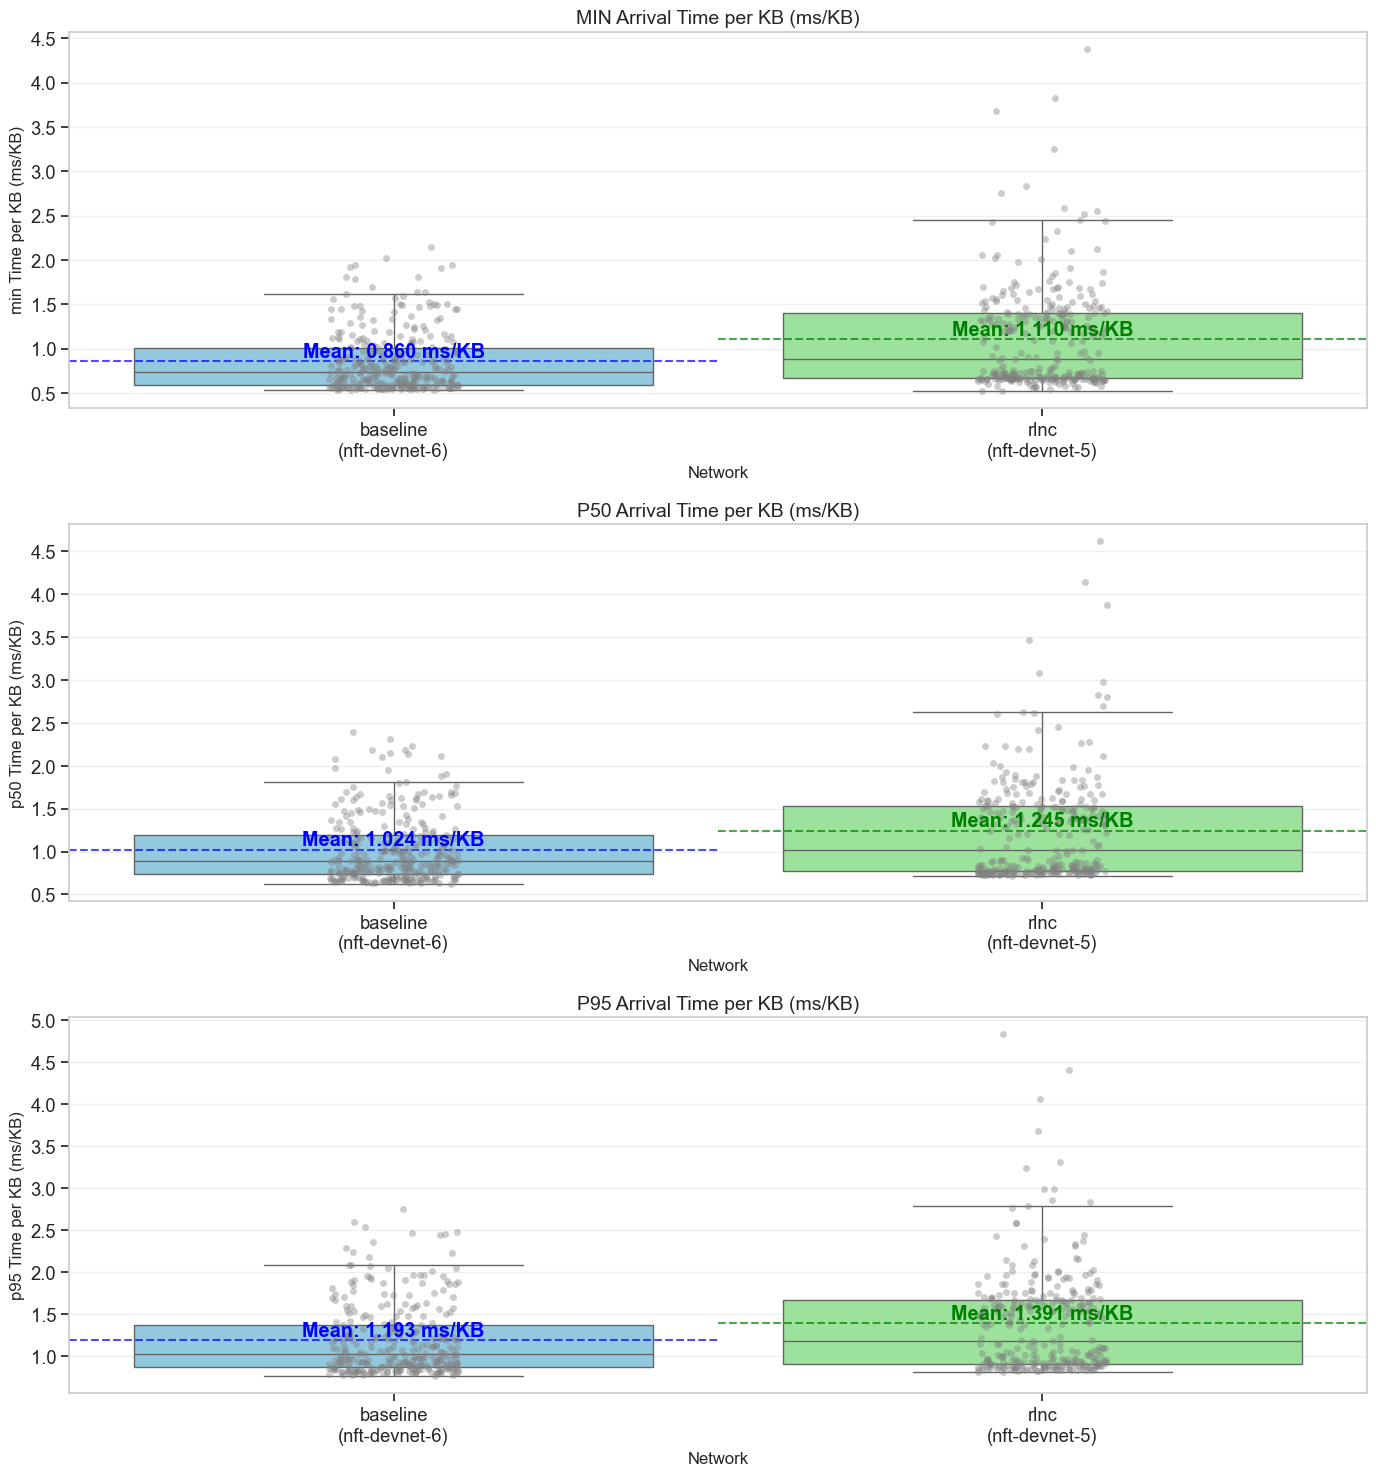

In [9]:
def plot_time_per_byte_distributions(all_metrics, metrics_to_plot):
    """
    Create boxplots to compare time-per-byte metrics across networks.
    
    Args:
        all_metrics (DataFrame): Combined metrics for all networks
        metrics_to_plot (list): List of metric names to plot
    """
    # Set up the figure with subplots for each metric
    fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(14, 5 * len(metrics_to_plot)))
    
    # If only one metric, make axes iterable
    if len(metrics_to_plot) == 1:
        axes = [axes]
    
    # Colors for each network
    colors = {'devnet-5': 'lightgreen', 'devnet-6': 'skyblue', 'devnet-7': 'coral'}
    
    # Create display labels for networks
    network_labels = {network: config["networks"][network]["label"] for network in all_metrics['network'].unique()}
    
    # Plot each metric
    for i, metric in enumerate(metrics_to_plot):
        # Create boxplot
        sns.boxplot(
            x='network', 
            y=f'{metric}_per_kb',
            hue='network', 
            data=all_metrics,
            palette=colors,
            ax=axes[i],
            showfliers=False  # Hide outliers for better visibility
        )
        
        # Add individual data points
        sns.stripplot(
            x='network', 
            y=f'{metric}_per_kb', 
            data=all_metrics,
            color='gray',
            alpha=0.4,
            jitter=True,
            ax=axes[i]
        )
        
        # Set axis labels and title
        axes[i].set_xlabel('Network', fontsize=12)
        axes[i].set_ylabel(f'{metric.replace("_time_per_byte", "")} Time per KB (ms/KB)', fontsize=12)
        axes[i].set_title(f'{metric.replace("_time_per_byte", "").upper()} Arrival Time per KB (ms/KB)', fontsize=14)
        
        # Rename x-tick labels
        current_labels = axes[i].get_xticklabels()
        new_labels = []
        for lbl in current_labels:
            network = lbl.get_text()
            if network in network_labels:
                new_labels.append(f'{network_labels[network]}\n({config["networks"][network]["network"]})')
            else:
                new_labels.append(network)
        
        axes[i].set_xticklabels(new_labels)
        
        # Add grid for readability
        axes[i].grid(True, axis='y', alpha=0.3)
        
        # Add average lines for each network
        networks = all_metrics['network'].unique()
        for j, network in enumerate(networks):
            network_data = all_metrics[all_metrics['network'] == network][f'{metric}_per_kb']
            if not network_data.empty:
                network_avg = network_data.mean()
                axes[i].axhline(
                    network_avg, 
                    color={'devnet-5': 'green', 'devnet-6': 'blue', 'devnet-7': 'red'}[network], 
                    linestyle='--', 
                    alpha=0.7,
                    xmin=j/len(networks),
                    xmax=(j+1)/len(networks)
                )
                
                # Add text with the average value
                axes[i].text(
                    j, network_avg, 
                    f'Mean: {network_avg:.3f} ms/KB', 
                    ha='center', va='bottom', 
                    color={'devnet-5': 'green', 'devnet-6': 'blue', 'devnet-7': 'red'}[network], 
                    fontweight='bold'
                )
    
    plt.tight_layout()
    return fig

# Plot time-per-byte distributions
metrics_to_plot = ['min_time_per_byte', 'p50_time_per_byte', 'p95_time_per_byte']
fig = plot_time_per_byte_distributions(all_metrics, metrics_to_plot)
plt.show()

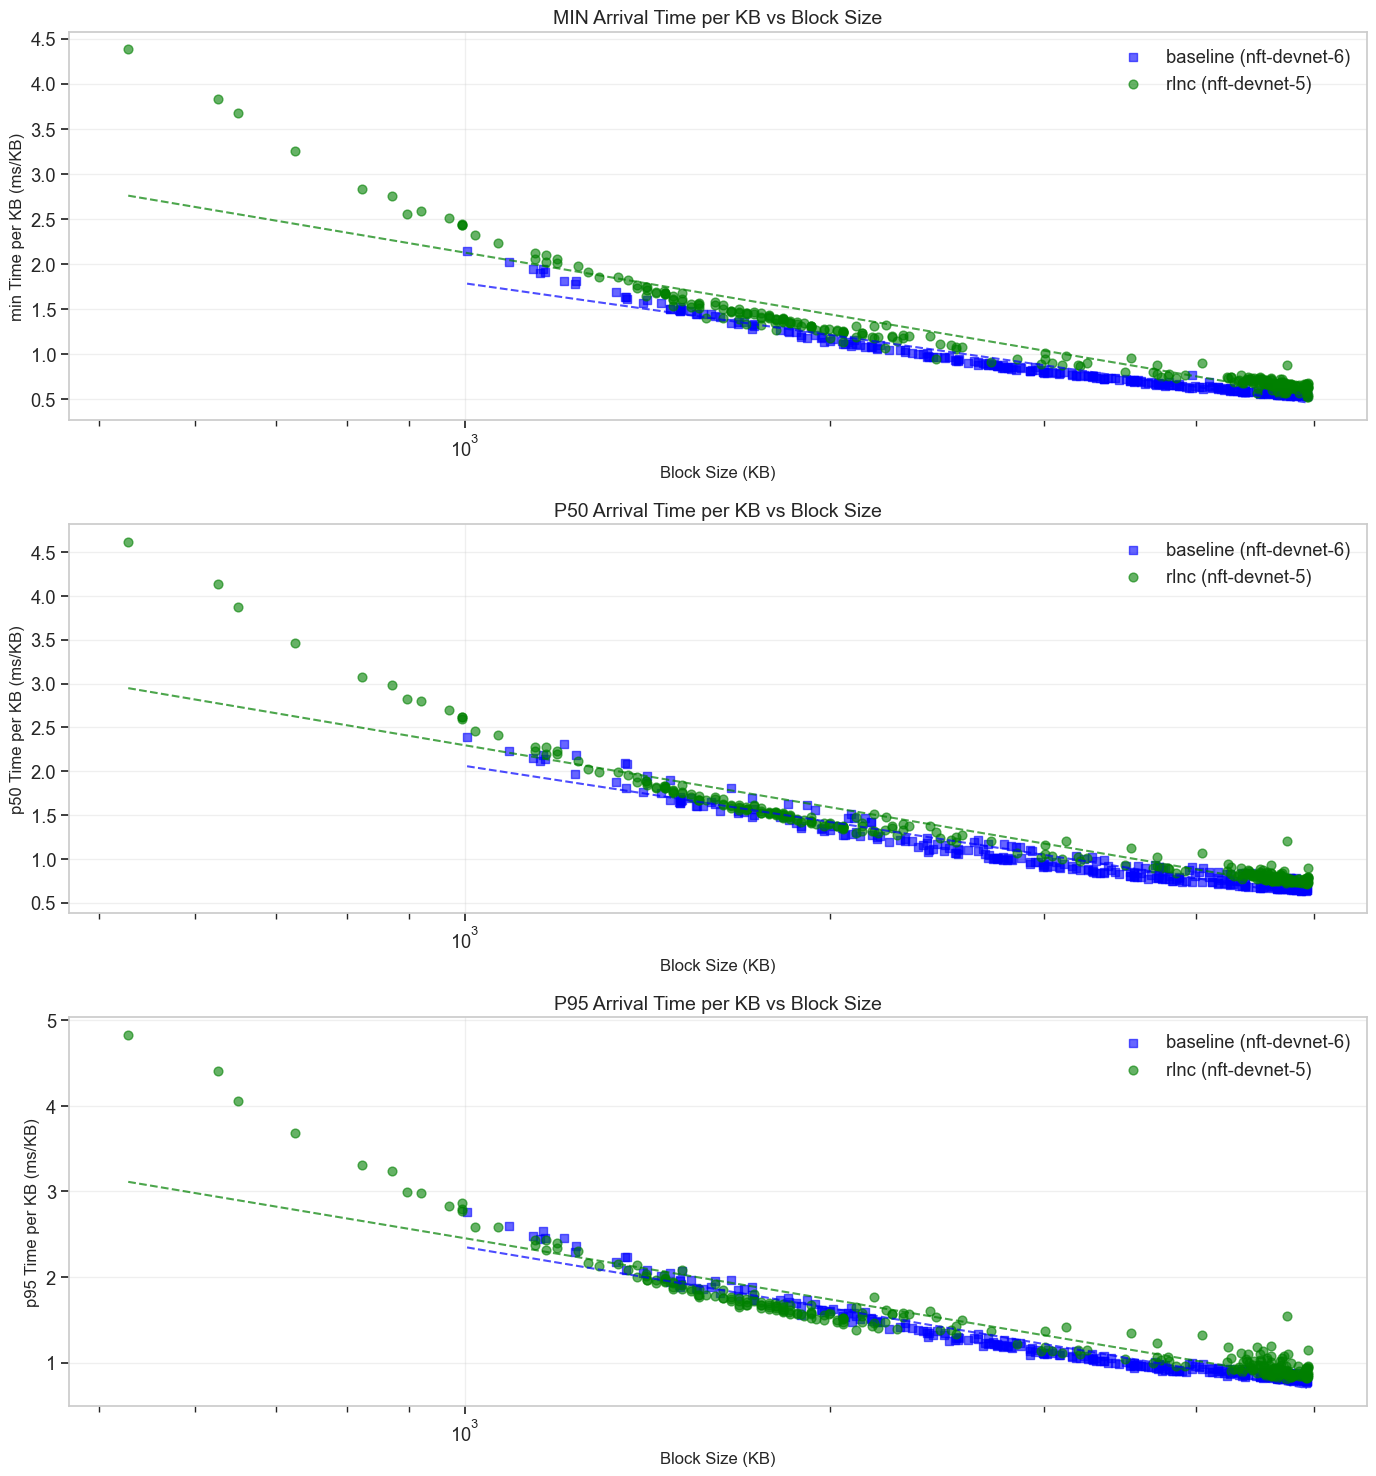

In [10]:
def plot_time_per_byte_by_size(metrics, metrics_to_plot):
    """
    Create scatter plots of time per byte vs block size for each network.
    
    Args:
        metrics (dict): Dictionary with network keys and metrics DataFrames
        metrics_to_plot (list): List of metric names to plot
    """
    # Set up the figure with subplots for each metric
    fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(14, 5 * len(metrics_to_plot)))
    
    # If only one metric, make axes iterable
    if len(metrics_to_plot) == 1:
        axes = [axes]
    
    # Colors and markers for each network
    colors = {'devnet-5': 'green', 'devnet-6': 'blue', 'devnet-7': 'red'}
    markers = {'devnet-5': 'o', 'devnet-6': 's', 'devnet-7': 'd'}
    
    # Create display labels for networks
    network_labels = {network: config["networks"][network]["label"] for network in metrics.keys()}
    
    # Plot each metric
    for i, metric in enumerate(metrics_to_plot):
        # Add scatter plots for each network
        for network, network_metrics in metrics.items():
            # Drop rows with missing data
            df = network_metrics.dropna(subset=[f'{metric}_per_kb', 'block_total_bytes'])
            
            # Convert to KB for better x-axis readability
            block_sizes_kb = df['block_total_bytes'] / 1024
            
            # Plot scatter with transparency
            axes[i].scatter(
                block_sizes_kb,
                df[f'{metric}_per_kb'],
                label=f'{network_labels[network]} ({config["networks"][network]["network"]})',
                color=colors[network],
                marker=markers[network],
                alpha=0.6,
                s=40
            )
            
            # Add regression line if enough points
            if len(df) > 5:
                # Use log scale for better fitting with highly variable block sizes
                x = np.log(block_sizes_kb)
                y = df[f'{metric}_per_kb']
                
                # Remove infinite values
                mask = np.isfinite(x) & np.isfinite(y)
                x, y = x[mask], y[mask]
                
                if len(x) > 5:  # Only fit if we have enough points after filtering
                    z = np.polyfit(x, y, 1)
                    p = np.poly1d(z)
                    
                    # Create points for the line
                    x_range = np.linspace(min(x), max(x), 100)
                    y_range = p(x_range)
                    
                    # Convert back from log scale
                    axes[i].plot(
                        np.exp(x_range),  # Convert back from log
                        y_range,
                        color=colors[network],
                        linestyle='--',
                        alpha=0.7
                    )
        
        # Set axis labels and title
        axes[i].set_xlabel('Block Size (KB)', fontsize=12)
        axes[i].set_ylabel(f'{metric.replace("_time_per_byte", "")} Time per KB (ms/KB)', fontsize=12)
        axes[i].set_title(f'{metric.replace("_time_per_byte", "").upper()} Arrival Time per KB vs Block Size', fontsize=14)
        
        # Add grid and legend
        axes[i].grid(True, alpha=0.3)
        axes[i].legend(loc='upper right')
        
        # Use log scale for x-axis due to wide range of block sizes
        axes[i].set_xscale('log')
    
    plt.tight_layout()
    return fig

# Plot time-per-byte vs block size
metrics_to_plot = ['min_time_per_byte', 'p50_time_per_byte', 'p95_time_per_byte']
fig = plot_time_per_byte_by_size(metrics, metrics_to_plot)
plt.show()

In [11]:
def create_efficiency_metrics_table(metrics, metrics_to_show):
    """
    Create a table showing efficiency metrics by block size bins.
    
    Args:
        metrics (dict): Dictionary with network keys and metrics DataFrames
        metrics_to_show (list): List of metrics to include in the table
    """
    # Collect all block sizes to determine appropriate bins
    all_block_sizes = []
    for network, network_metrics in metrics.items():
        valid_sizes = network_metrics['block_total_bytes'].dropna().values
        all_block_sizes.extend(valid_sizes)
    
    # Determine bin edges using quantiles
    if len(all_block_sizes) > 10:
        # Use quartiles for simplicity (4 bins)
        quartiles = np.percentile(all_block_sizes, [0, 25, 50, 75, 100])
        size_bins = [0] + [q for q in quartiles if q > 0]
        size_bins = sorted(list(set(size_bins)))  # Remove duplicates and ensure sorted
        
        # If we have very small ranges, use reasonable defaults
        if len(size_bins) < 3:
            size_bins = [0, np.median(all_block_sizes), max(all_block_sizes) * 1.1]
    else:
        # Not enough data, use some reasonable defaults
        size_bins = [0, np.median(all_block_sizes), float('inf')]
    
    # Add infinity as the last bin edge if it's not there
    if size_bins[-1] != float('inf'):
        size_bins.append(float('inf'))
    
    # Create labels for the bins
    bin_labels = []
    for i in range(len(size_bins) - 1):
        if size_bins[i+1] == float('inf'):
            bin_labels.append(f'>{size_bins[i]/1024:.1f}KB')
        else:
            bin_labels.append(f'{size_bins[i]/1024:.1f}-{size_bins[i+1]/1024:.1f}KB')
    
    # Process each network's data
    network_binned_data = {}
    
    for network, network_metrics in metrics.items():
        # Drop NaN values and create a copy for safe modification
        network_metrics_filtered = network_metrics.dropna(subset=['block_total_bytes']).copy()
        
        # Add block size bin column using .loc to avoid SettingWithCopyWarning
        network_metrics_filtered.loc[:, 'block_size_bin'] = pd.cut(
            network_metrics_filtered['block_total_bytes'], 
            bins=size_bins, 
            labels=bin_labels
        )
        
        # Select columns to aggregate
        cols_to_agg = [f'{metric}_per_kb' for metric in metrics_to_show] + ['block_total_bytes']
        
        # Group by block size bin and aggregate with observed=True
        agg_dict = {col: 'mean' for col in cols_to_agg}
        agg_dict['block_total_bytes'] = ['mean', 'count']
        
        binned = network_metrics_filtered.groupby('block_size_bin', observed=True).agg(agg_dict)
        binned.columns = ['_'.join(col).strip() for col in binned.columns.values]
        binned = binned.reset_index()
        
        # Rename columns for clarity
        binned = binned.rename(columns={'block_total_bytes_mean': f'{network}_avg_size', 
                                       'block_total_bytes_count': f'{network}_count'})
        
        for metric in metrics_to_show:
            binned = binned.rename(columns={f'{metric}_per_kb_mean': f'{network}_{metric}'})
            
        network_binned_data[network] = binned
    
    # Merge all networks' data
    network_keys = list(metrics.keys())
    if network_keys:
        merged_data = network_binned_data[network_keys[0]].copy()
        
        for i in range(1, len(network_keys)):
            merged_data = pd.merge(merged_data, network_binned_data[network_keys[i]], 
                                  on='block_size_bin', how='outer')
    else:
        # Handle empty metrics case
        return go.Figure()
    
    # Create display labels for networks
    network_labels = {network: config["networks"][network]["label"] for network in metrics.keys()}
    
    # Prepare data for the table
    table_data = [
        ['Block Size Range'] + 
        [f'{network_labels[network]} Count' for network in network_keys] +
        [f'{network_labels[network]} Avg Size (KB)' for network in network_keys]
    ]
    
    # Add headings for each metric
    for metric in metrics_to_show:
        table_data[0].extend([f'{network_labels[network]} {metric.replace("_time_per_byte", "")} (ms/KB)' for network in network_keys])
    
    # Fill in the data
    for _, row in merged_data.iterrows():
        table_row = [row['block_size_bin']]
        
        # Add counts for each network
        for network in network_keys:
            count_col = f'{network}_count'
            if count_col in row and not pd.isna(row[count_col]):
                table_row.append(f"{int(row[count_col])}")
            else:
                table_row.append('0')
        
        # Add average sizes for each network (converted to KB)
        for network in network_keys:
            size_col = f'{network}_avg_size'
            if size_col in row and not pd.isna(row[size_col]):
                table_row.append(f"{row[size_col]/1024:.1f}")
            else:
                table_row.append('N/A')
        
        # Add metrics for each network
        for metric in metrics_to_show:
            for network in network_keys:
                metric_col = f'{network}_{metric}'
                if metric_col in row and not pd.isna(row[metric_col]):
                    table_row.append(f"{row[metric_col]:.3f}")
                else:
                    table_row.append('N/A')
        
        table_data.append(table_row)
    
    # Create table figure
    table_fig = go.Figure(data=[go.Table(
        header=dict(
            values=table_data[0],
            fill_color='paleturquoise',
            align='center',
            font=dict(size=12)
        ),
        cells=dict(
            values=[[row[i] for row in table_data[1:]] for i in range(len(table_data[0]))],
            fill_color='white',
            align='center',
            font=dict(size=11)
        )
    )])
    
    table_fig.update_layout(
        title="Block Processing Efficiency (Time per Size) by Block Size Range",
        height=400,
        width=1200
    )
    
    return table_fig

# Create efficiency metrics table
metrics_to_show = ['min_time_per_byte', 'p50_time_per_byte', 'p95_time_per_byte']
fig = create_efficiency_metrics_table(metrics, metrics_to_show)
fig.show()

In [12]:
def plot_block_size_over_time(metrics, window_size=16):
    """
    Create a scatter plot of block size over time (by slot) for each network, with a moving average.
    
    Args:
        metrics (dict): Dictionary with network keys and metrics DataFrames
        window_size (int): Size of the moving average window
        
    Returns:
        plotly.graph_objects.Figure: The plotly figure
    """
    # Create figure
    fig = go.Figure()
    
    # Colors for each network
    colors = {'devnet-5': 'green', 'devnet-6': 'blue', 'devnet-7': 'red'}
    
    # Create display labels for networks
    network_labels = {network: config["networks"][network]["label"] for network in metrics.keys()}
    
    # Add scatter plot for each network
    for network, network_metrics in metrics.items():
        # Sort metrics by slot
        network_metrics = network_metrics.sort_values('slot')
        
        # Drop rows with missing data
        df = network_metrics.dropna(subset=['block_total_bytes', 'slot'])
        
        # Convert block size to KB for better readability
        block_sizes_kb = df['block_total_bytes'] / 1024
        
        # Calculate moving average
        if len(df) >= window_size:
            ma = block_sizes_kb.rolling(window=window_size).mean()
        else:
            ma = pd.Series([None] * len(block_sizes_kb))
        
        # Add scatter plot for raw data
        fig.add_trace(go.Scatter(
            x=df['slot'],
            y=block_sizes_kb,
            mode='markers',
            name=f'{network_labels[network]} Raw',
            marker=dict(
                color=colors[network],
                size=6,
                opacity=0.5
            ),
            hovertemplate='Slot: %{x}<br>Block Size: %{y:.1f} KB'
        ))
        
        # Add line for moving average
        fig.add_trace(go.Scatter(
            x=df['slot'],
            y=ma,
            mode='lines',
            name=f'{network_labels[network]} {window_size}-Slot MA',
            line=dict(
                color=colors[network],
                width=2
            ),
            hovertemplate='Slot: %{x}<br>Avg Block Size: %{y:.1f} KB'
        ))
    
    # Update layout
    fig.update_layout(
        title=f"Block Size Over Time by Network with {window_size}-Slot Moving Average",
        xaxis=dict(
            title="Slot",
            title_font=dict(size=14),
            gridcolor='lightgray'
        ),
        yaxis=dict(
            title="Block Size (KB)",
            title_font=dict(size=14),
            gridcolor='lightgray'
        ),
        legend=dict(x=0.01, y=0.99, bgcolor='rgba(255,255,255,0.8)'),
        hovermode='closest',
        plot_bgcolor='white',
        height=600,
        width=1000
    )
    
    return fig

# Create and display the block size over time plot
fig = plot_block_size_over_time(metrics, window_size=16)
fig.show()